In [31]:
import ee

ee.Authenticate(auth_mode='notebook')
ee.Initialize(project = 'ee-gsingh')

from geeml.utils import eeprint

In [32]:
# Enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/ee-gsingh/assets/postdoc/'
# ------------------------------------------------

In [33]:
# Import other packages used in the tutorial
%matplotlib inline
import geemap
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from pprint import pprint 

In [34]:
#@title Routines from Part 1

def trunc(values, dec = 3):
    '''Truncate a 1-D array to dec decimal places.'''
    return np.trunc(values*10**dec)/(10**dec)

# Display an image in a one percent linear stretch.
def display_ls(image, map, name, centered = False):
    bns = image.bandNames().length().getInfo()
    if bns == 3:
        image = image.rename('B1', 'B2', 'B3')
        pb_99 = ['B1_p99', 'B2_p99', 'B3_p99']
        pb_1 = ['B1_p1', 'B2_p1', 'B3_p1']
        img = ee.Image.rgb(image.select('B1'), image.select('B2'), image.select('B3'))
    else:
        image = image.rename('B1')
        pb_99 = ['B1_p99']
        pb_1 = ['B1_p1']
        img = image.select('B1')
    percentiles = image.reduceRegion(ee.Reducer.percentile([1, 99]), maxPixels=1e11)
    mx = percentiles.values(pb_99)
    if centered:
        mn = ee.Array(mx).multiply(-1).toList()
    else:
        mn = percentiles.values(pb_1)
    map.addLayer(img, {'min': mn, 'max': mx}, name)

def collect(aoi, t1a ,t1b, t2a, t2b):
    try:
        im1 = ee.Image( ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t1a), ee.Date(t1b))
                               .filter(ee.Filter.contains(rightValue=aoi,leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               .first()
                               .clip(aoi) )
        im2 = ee.Image( ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t2a), ee.Date(t2b))
                               .filter(ee.Filter.contains(rightValue=aoi,leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               .first()
                               .clip(aoi) )
        timestamp = im1.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        timestamp = im2.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        return (im1, im2)
    except Exception as e:
        print('Error: %s'%e)

def covarw(image, weights=None, scale=20, maxPixels=1e10):
    '''Return the centered image and its weighted covariance matrix.'''
    try:
        geometry = image.geometry()
        bandNames = image.bandNames()
        N = bandNames.length()
        if weights is None:
            weights = image.constant(1)
        weightsImage = image.multiply(ee.Image.constant(0)).add(weights)
        means = image.addBands(weightsImage) \
                    .reduceRegion(ee.Reducer.mean().repeat(N).splitWeights(),
                                scale = scale,
                                maxPixels = maxPixels) \
                    .toArray() \
                    .project([1])
        centered = image.toArray().subtract(means)
        B1 = centered.bandNames().get(0)
        b1 = weights.bandNames().get(0)
        nPixels = ee.Number(centered.reduceRegion(ee.Reducer.count(),
                                                scale=scale,
                                                maxPixels=maxPixels).get(B1))
        sumWeights = ee.Number(weights.reduceRegion(ee.Reducer.sum(),
                                                    geometry=geometry,
                                                    scale=scale,
                                                    maxPixels=maxPixels).get(b1))
        covw = centered.multiply(weights.sqrt()) \
                    .toArray() \
                    .reduceRegion(ee.Reducer.centeredCovariance(),
                                    geometry=geometry,
                                    scale=scale,
                                    maxPixels=maxPixels) \
                    .get('array')
        covw = ee.Array(covw).multiply(nPixels).divide(sumWeights)
        return (centered.arrayFlatten([bandNames]), covw)
    except Exception as e:
        print('Error: %s'%e)

def corr(cov):
    '''Transfrom covariance matrix to correlation matrix.'''
    # Diagonal matrix of inverse sigmas.
    sInv = cov.matrixDiagonal().sqrt().matrixToDiag().matrixInverse()
    # Transform.
    corr = sInv.matrixMultiply(cov).matrixMultiply(sInv).getInfo()
    # Truncate.
    return [list(map(trunc, corr[i])) for i in range(len(corr))]

def geneiv(C,B):
    '''Return the eignvalues and eigenvectors of the generalized eigenproblem
       C*X = lambda*B*X'''
    try:
        C = ee.Array(C)
        B = ee.Array(B)
        #  Li = choldc(B)^-1
        Li = ee.Array(B.matrixCholeskyDecomposition().get('L')).matrixInverse()
        # Solve symmetric, ordinary eigenproblem Li*C*Li^T*x = lambda*x
        Xa = Li.matrixMultiply(C) \
            .matrixMultiply(Li.matrixTranspose()) \
            .eigen()
        # Eigenvalues as a row vector.
        lambdas = Xa.slice(1, 0, 1).matrixTranspose()
        # Eigenvectors as columns.
        X = Xa.slice(1, 1).matrixTranspose()
        # Generalized eigenvectors as columns, Li^T*X
        eigenvecs = Li.matrixTranspose().matrixMultiply(X)
        return (lambdas, eigenvecs)
    except Exception as e:
        print('Error: %s'%e)

def mad_run(image1, image2, scale=20):
    '''The MAD transformation of two multiband images.'''
    try:
        image = image1.addBands(image2)
        nBands = image.bandNames().length().divide(2)
        centeredImage,covarArray = covarw(image,scale=scale)
        bNames = centeredImage.bandNames()
        bNames1 = bNames.slice(0,nBands)
        bNames2 = bNames.slice(nBands)
        centeredImage1 = centeredImage.select(bNames1)
        centeredImage2 = centeredImage.select(bNames2)
        s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
        s22 = covarArray.slice(0, nBands).slice(1, nBands)
        s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
        s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)
        c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
        b1 = s11
        c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
        b2 = s22
        # Solution of generalized eigenproblems.
        lambdas, A = geneiv(c1, b1)
        _,       B = geneiv(c2, b2)
        rhos = lambdas.sqrt().project(ee.List([1]))
        # MAD variances.
        sigma2s = rhos.subtract(1).multiply(-2).toList()
        sigma2s = ee.Image.constant(sigma2s)
        # Ensure sum of positive correlations between X and U is positive.
        tmp = s11.matrixDiagonal().sqrt()
        ones = tmp.multiply(0).add(1)
        tmp = ones.divide(tmp).matrixToDiag()
        s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(),[0]).transpose()
        A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
        # Ensure positive correlation.
        tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
        tmp = tmp.divide(tmp.abs()).matrixToDiag()
        B = B.matrixMultiply(tmp)
        # Canonical and MAD variates as images.
        centeredImage1Array = centeredImage1.toArray().toArray(1)
        centeredImage2Array = centeredImage2.toArray().toArray(1)
        U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                    .arrayProject([0]) \
                    .arrayFlatten([bNames2])
        V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                    .arrayProject([0]) \
                    .arrayFlatten([bNames2])
        MAD = U.subtract(V)
        # Chi-square image.
        Z = MAD.pow(2) \
               .divide(sigma2s) \
               .reduce(ee.Reducer.sum())
        return (U, V, MAD, Z)
    except Exception as e:
        print('Error: %s'%e)

In [35]:
#@title The iMAD code
def chi2cdf(Z,df):
    '''Chi-square cumulative distribution function with df degrees of freedom.'''
    return ee.Image(Z.divide(2)).gammainc(ee.Number(df).divide(2))

def imad(current,prev):
    '''Iterator function for iMAD.'''
    done =  ee.Number(ee.Dictionary(prev).get('done'))
    return ee.Algorithms.If(done, prev, imad1(current, prev))

def imad1(current,prev):
    '''Iteratively re-weighted MAD.'''
    image = ee.Image(ee.Dictionary(prev).get('image'))
    Z = ee.Image(ee.Dictionary(prev).get('Z'))
    allrhos = ee.List(ee.Dictionary(prev).get('allrhos'))
    nBands = image.bandNames().length().divide(2)
    weights = chi2cdf(Z,nBands).subtract(1).multiply(-1)
    scale = ee.Dictionary(prev).getNumber('scale')
    niter = ee.Dictionary(prev).getNumber('niter')
    # Weighted stacked image and weighted covariance matrix.
    centeredImage, covarArray = covarw(image, weights, scale)
    bNames = centeredImage.bandNames()
    bNames1 = bNames.slice(0, nBands)
    bNames2 = bNames.slice(nBands)
    centeredImage1 = centeredImage.select(bNames1)
    centeredImage2 = centeredImage.select(bNames2)
    s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
    s22 = covarArray.slice(0, nBands).slice(1, nBands)
    s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
    s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)
    c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
    b1 = s11
    c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
    b2 = s22
    # Solution of generalized eigenproblems.
    lambdas, A = geneiv(c1, b1)
    _, B       = geneiv(c2, b2)
    rhos = lambdas.sqrt().project(ee.List([1]))
    # Test for convergence.
    lastrhos = ee.Array(allrhos.get(-1))
    done = rhos.subtract(lastrhos) \
               .abs() \
               .reduce(ee.Reducer.max(), ee.List([0])) \
               .lt(ee.Number(0.0001)) \
               .toList() \
               .get(0)
    allrhos = allrhos.cat([rhos.toList()])
    # MAD variances.
    sigma2s = rhos.subtract(1).multiply(-2).toList()
    sigma2s = ee.Image.constant(sigma2s)
    # Ensure sum of positive correlations between X and U is positive.
    tmp = s11.matrixDiagonal().sqrt()
    ones = tmp.multiply(0).add(1)
    tmp = ones.divide(tmp).matrixToDiag()
    s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(), [0]).transpose()
    A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
    # Ensure positive correlation.
    tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
    tmp = tmp.divide(tmp.abs()).matrixToDiag()
    B = B.matrixMultiply(tmp)
    # Canonical and MAD variates.
    centeredImage1Array = centeredImage1.toArray().toArray(1)
    centeredImage2Array = centeredImage2.toArray().toArray(1)
    U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames1])
    V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames2])
    iMAD = U.subtract(V)
    # Chi-square image.
    Z = iMAD.pow(2) \
              .divide(sigma2s) \
              .reduce(ee.Reducer.sum())
    return ee.Dictionary({'done': done, 'scale': scale, 'niter': niter.add(1),
                          'image': image, 'allrhos': allrhos, 'Z': Z, 'iMAD': iMAD})

In [36]:
#@title Run iMAD algorithm as export task
def run_imad(aoi, image1, image2, assetId, scale=20, maxiter=100):
    try:
        N = image1.bandNames().length().getInfo()
        imadnames = ['iMAD'+str(i+1) for i in range(N)]
        imadnames.append('Z')
        # Maximum iterations.
        inputlist = ee.List.sequence(1, maxiter)
        first = ee.Dictionary({'done':0,
                            'scale': scale,
                            'niter': ee.Number(0),
                            'image': image1.addBands(image2),
                            'allrhos': [ee.List.sequence(1, N)],
                            'Z': ee.Image.constant(0),
                            'iMAD': ee.Image.constant(0)})
        # Iteration.
        result = ee.Dictionary(inputlist.iterate(imad, first))
        # Retrieve results.
        iMAD = ee.Image(result.get('iMAD')).clip(aoi)
        rhos = ee.String.encodeJSON(ee.List(result.get('allrhos')).get(-1))
        Z = ee.Image(result.get('Z'))
        niter = result.getNumber('niter')
        # Export iMAD and Z as a single image, including rhos and number of iterations in properties.
        iMAD_export = ee.Image.cat(iMAD, Z).rename(imadnames).set('rhos', rhos, 'niter', niter)
        assexport = ee.batch.Export.image.toAsset(iMAD_export,
                        description='assetExportTask',
                        assetId=assetId, scale=scale, maxPixels=1e10)
        assexport.start()
        print('Exporting iMAD to %s\n task id: %s'%(assetId, str(assexport.id)))
    except Exception as e:
        print('Error: %s'%e)

In [37]:
def createComposite(imageCollection: str, points: ee.Geometry, year: int, period:str):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
        period (str): Either values of first (Sept-09), second(oct-Nov) or both. 
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    if period == 'first':
        startDate = f'{year}-09-01'
        endDate = f'{year}-10-01'
    elif period == 'second':
        startDate = f'{year}-10-22'
        endDate = f'{year}-11-27'
        # startDate = f'{year}-10-01'
        # endDate = f'{year}-12-01'
        

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(points).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000).select(["B2","B3","B4","B5","B6","B7","B8","B11","B12"])

In [38]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/postdoc/aliens_sep2018_bioscape2023')
eeprint(pts.limit(5))

aoi = pts.geometry().bounds()

composite2018 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2018,
                period='first').select('B.*')

# Create a composite for 2023
composite2023 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2023,
                period='second').select('B.*')

eeprint(composite2018.bandNames())


In [9]:
Map = geemap.Map()
Map.addLayer(aoi, {}, 'Area of Interest')
Map.addLayer(composite2018, {'bands':['B4', 'B3', 'B2'],'min': 0, 'max': 0.3}, 'Composite 2018')
Map.addLayer(composite2023, {'bands':['B4', 'B3', 'B2'],'min': 0, 'max': 0.3}, 'Composite 2023')
Map.centerObject(aoi, 10)
Map

Map(center=[-33.8645494304087, 19.250142136824007], controls=(WidgetControl(options=['position', 'transparent_…

In [23]:
asset_path = f'{EXPORT_PATH}WC_2018_2023_imad'
bands = ["B2","B3","B4","B5","B6","B7","B8","B11","B12"]
run_imad(aoi, composite2018.select(bands).clip(aoi), composite2023.select(bands).clip(aoi), asset_path)

Exporting iMAD to projects/ee-gsingh/assets/postdoc/WC_2018_2023_imad
 task id: SPO4KKFAWSRYRO7XUP4WIUGI


In [10]:
M1 = geemap.Map()
M1.centerObject(aoi, 11)
display_ls(im1.select(visbands), M1, 'im1')
display_ls(im2.select(visbands), M1, 'im2')
display_ls(im_imad.select('iMAD1', 'iMAD2', 'iMAD3'), M1, 'iMAD123', True)

M1

NameError: name 'im1' is not defined

In [10]:
image = ee.Image("projects/ee-gsingh/assets/postdoc/WC_2018_2023_imad")
eeprint(image.bandNames())

In [11]:
# Select chi square statistic band
im_z = image.select('Z')
# p-values image.
pval = chi2cdf(image.select('Z'), 9).subtract(1).multiply(-1).rename('pval')
# No-change mask (use p-values greater than 0.1).
noChangeMask = pval.gt(0.1)

NameError: name 'chi2cdf' is not defined

In [15]:
eeprint(im_z.reduceRegion(reducer=ee.Reducer.percentile([99]), geometry=aoi, scale=10, maxPixels=1e10))

In [17]:
M1 = geemap.Map()
M1.centerObject(aoi, 11)
display_ls(pval, M1, 'im1')
display_ls(noChangeMask, M1, 'im2')
display_ls(image.select('iMAD1', 'iMAD2', 'iMAD3'), M1, 'iMAD123', True)
M1.addLayer(composite2018, {'bands':['B4', 'B3', 'B2'],'min': 0, 'max': 0.3}, 'Composite 2018')
M1.addLayer(composite2023, {'bands':['B4', 'B3', 'B2'],'min': 0, 'max': 0.3}, 'Composite 2023')
M1.addLayer(im_z.lt(95.811), {}, 'chsq thresholded')
M1.addLayer(im_z.lt(2476.56719663), {}, 'chsq thresholded(canty)')
# Style by 'change' attribute: 0 → blue, 1 → red
styled_fc = pts.map(lambda f: f.set('style', {
    'color': ee.Algorithms.If(f.get('change'), 'red', 'blue'),
    'pointSize': 3,
    'pointShape': 'circle'
}))
M1.addLayer(styled_fc.style(**{'styleProperty': 'style'}), {}, 'Change Points')
M1

Map(center=[-33.8645494304087, 19.250142136824007], controls=(WidgetControl(options=['position', 'transparent_…

In [53]:
import geemap.chart as chart

my_sample = image.select('Z').sample(aoi, 1000)
property = "Z"
options = {
    "title": "Dstribution of Z scores",
    "xlabel": "X2 statistic",
    "ylabel": "Pixel count",
    "colors": ["#4b1d99"],
}
# Generate histogram with default number of bins:

chart.feature_histogram(my_sample, property, minBucketWidth=500, **options)

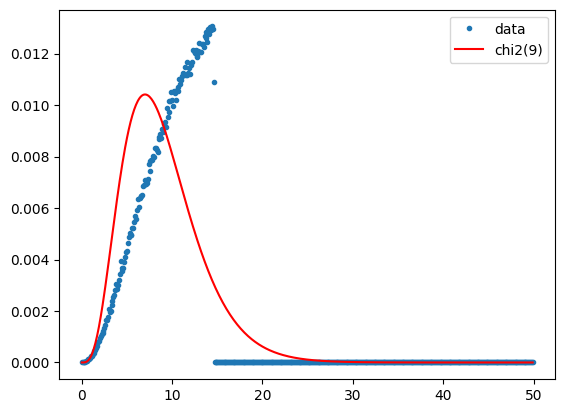

In [ ]:
scale = 10
# p-values image.
pval = chi2cdf(im_z, 9).subtract(1).multiply(-1).rename('pval')
# No-change mask (use p-values greater than 0.1).
noChangeMask = pval.gt(0.1)
hist = im_z.updateMask(noChangeMask).reduceRegion(ee.Reducer \
           .fixedHistogram(0, 50, 500), aoi, scale=scale, maxPixels=1e11) \
           .get('Z').getInfo()
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.plot(x, y, '.', label = 'data')
plt.plot(x, chi2.pdf(x, 9)/10, '-r', label='chi2(9)')
plt.legend()
plt.show()

In [20]:
zScores = im_z.reduceRegions(
    collection=pts.select(['change']),
    reducer=ee.Reducer.mean(),
    scale=10
)

Zdf = ee.data.computeFeatures({
    'expression': zScores,
    'fileFormat': 'PANDAS_DATAFRAME'
})

result = Zdf[['change', 'mean']].dropna(axis=0, how='any')

In [21]:
result

change        mean
0          0  225.522388
1          0  839.411226
2          0  550.928706
3          0  246.963698
4          0   45.546722
...      ...         ...
1683       0   13.532661
1684       0    3.827668
1685       0  156.091464
1686       0   27.728519
1687       1   95.811777

[1688 rows x 2 columns]

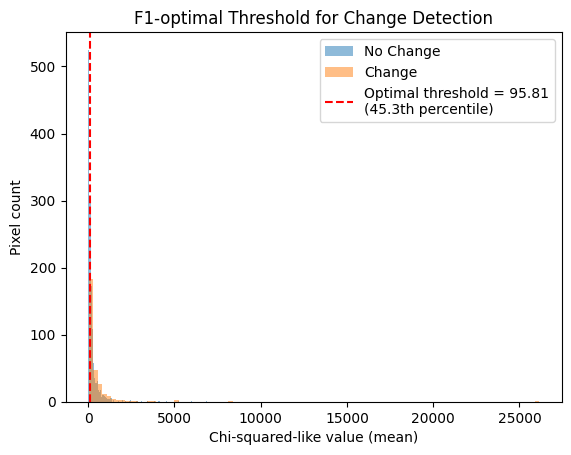

Optimal threshold (F1-maximizing): 95.8118
Threshold percentile: 45.26%


In [22]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Inputs: result['mean'] = test statistic (e.g., chi2); result['change'] = 0/1 labels
y_true = result['change'].to_numpy()
chi2_vals = result['mean'].to_numpy()

# 1. Precision-recall curve
prec, rec, thresholds = precision_recall_curve(y_true, chi2_vals)

# 2. Compute F1 scores
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = f1_scores.argmax()
optimal_threshold = thresholds[best_idx]

# 3. Compute percentile of threshold in chi2_vals
percentile = np.sum(chi2_vals < optimal_threshold) / len(chi2_vals) * 100

# 4. Optional: Plot histogram
plt.hist(chi2_vals[y_true == 0], bins=100, alpha=0.5, label='No Change')
plt.hist(chi2_vals[y_true == 1], bins=100, alpha=0.5, label='Change')
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Optimal threshold = {optimal_threshold:.2f}\n({percentile:.1f}th percentile)')
plt.xlabel('Chi-squared-like value (mean)')
plt.ylabel('Pixel count')
plt.legend()
plt.title('F1-optimal Threshold for Change Detection')
plt.show()

# 5. Print result
print(f"Optimal threshold (F1-maximizing): {optimal_threshold:.4f}")
print(f"Threshold percentile: {percentile:.2f}%")


Class priors from data: no-change = 0.826, change = 0.174


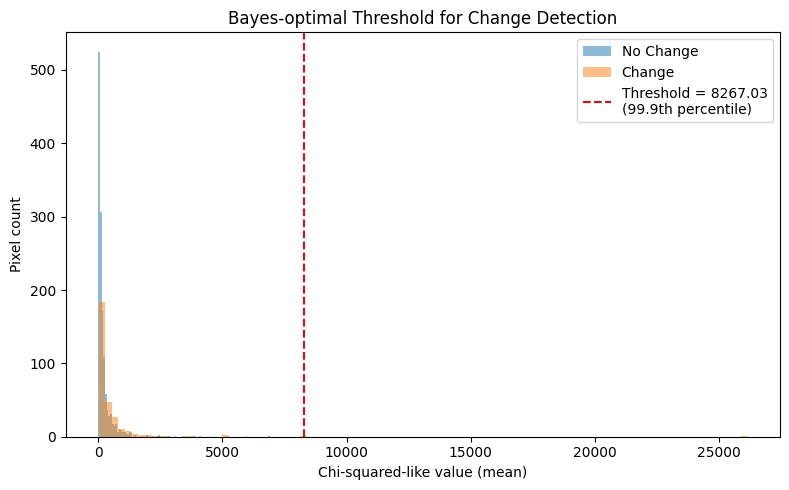

Bayes-optimal threshold: 8267.0282
Threshold percentile: 99.88%


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# 0. Extract data
y_true = result['change'].to_numpy()          # binary: 1 = change, 0 = no-change
chi2_vals = result['mean'].to_numpy()         # test statistic (higher = more likely change)

# 1. Calculate class proportions (priors)
counts = result['change'].value_counts(normalize=True).sort_index()
p_nochange = counts.get(0, 0.0)
p_change = counts.get(1, 0.0)

print(f"Class priors from data: no-change = {p_nochange:.3f}, change = {p_change:.3f}")

# 2. Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, chi2_vals)

# 3. Compute total expected error at each threshold (Bayes minimum-error rule)
total_error = p_nochange * fpr + p_change * (1 - tpr)
best_idx = np.argmin(total_error)
optimal_threshold = thresholds[best_idx]

# 4. Compute percentile of threshold
percentile = np.sum(chi2_vals < optimal_threshold) / len(chi2_vals) * 100

# 5. Plot histogram and threshold
plt.figure(figsize=(8, 5))
plt.hist(chi2_vals[y_true == 0], bins=100, alpha=0.5, label='No Change')
plt.hist(chi2_vals[y_true == 1], bins=100, alpha=0.5, label='Change')
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Threshold = {optimal_threshold:.2f}\n({percentile:.1f}th percentile)')
plt.xlabel('Chi-squared-like value (mean)')
plt.ylabel('Pixel count')
plt.title('Bayes-optimal Threshold for Change Detection')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Print final results
print(f"Bayes-optimal threshold: {optimal_threshold:.4f}")
print(f"Threshold percentile: {percentile:.2f}%")


In [24]:
from sklearn.metrics import precision_recall_curve, f1_score

# chi2_vals: your test statistic (higher = more likely change)
# true_labels: 1 for change, 0 for no-change
prec, rec, thresholds = precision_recall_curve(result['change'], result['mean'])

# Compute F1 scores at each threshold
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)  # avoid div by 0
best_idx = f1_scores.argmax()
optimal_threshold = thresholds[best_idx]
optimal_threshold


np.float64(95.811777130597)

In [50]:
rhos = ee.List(image.get('rhos')).getInfo()

# Standardize to no change sigmas.
sigma2s = ee.Image.constant([2*(1-x) for x in eval(rhos)])
im_imadstd = image.select('iMAD.*').divide(sigma2s.sqrt())
# Collect training data.
training = im_imadstd.sample(region=aoi, scale=10, numPixels=50000)
# Train the clusterer.
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
# Classify the standardized imad image.
result = im_imadstd.cluster(clusterer)

In [51]:
M1.addLayer(result.randomVisualizer(), {}, 'Clustered iMAD')

In [14]:
# Proportion of KZN area samppled in Wessels
prop = ((1100000*900)/1000000)/92100
area = aoi.area(5).divide(1e6).getInfo()  # Area of aoi in km2
print('Area of the area of interest in km2: %s'%area)
print('Proportion of KZN area sampled in Wessels: %s'%prop)
# number of required samples
nSamples = (area*prop)*1000000/100
print('Number of required samples: %s'%nSamples)
# number of min classes (at least 1% of sample size)
print('Number of minimum samples per class: %s'%int(nSamples*0.01+1))
# Colditz, R.R., 2015. An evaluation of different training sample allocation schemes for discrete and continuous land cover classification using decision tree-based algorithms. Remote Sensing, 7(8), pp.9655-9681.

Area of the area of interest in km2: 1495.0742915824985
Proportion of KZN area sampled in Wessels: 0.010749185667752443
Number of required samples: 160708.31147303732
Number of minimum samples per class: 1608


### Extracting data to work locally with scikit-learn - reproducing wesssels et al., 2016

#### Random forest

In [ ]:
# Steps to follow:
# create s2 classification based on 2018 reference data and composite imagery
    # extract data for 2018 as gpd
    # download image for 2018 and 2023
    # classify 2018
    # upload to gee
# Apply change mask
# Calculate area proportions for each class
# Calculate number of samples per class
# perform stratified sample of 2023 composite with 2018 classified image

In [1]:
import ee
try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()

import geemap
from geeml.utils import eeprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\geemap\conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


#### Extracting 2018 data from Earth Engine

In [2]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/postdoc/aliens_sep2018_bioscape2023')
eeprint(pts.limit(5))

In [3]:
class prepareTrainingData:
    """This class prepares training data for the earth engine random forest model."""
    def __init__(self, points: ee.FeatureCollection, targetProperty: str, nFolds: int, proj: str = 'EPSG:4326'):
        """
        Args:
            points (ee.FeatureCollection): ee.FeatureCollection
            targetProperty (str): name of the property that contains the target variable
            nFolds (int): number of folds for cross validation
            proj (str): projection of the data
        """

        self.points = points
        self.targetProperty = targetProperty
        self.nFolds = nFolds
        self.proj = proj

    def addCoordProperty(self, features: ee.FeatureCollection) -> ee.FeatureCollection:
        """
        This function adds coordinates to the points

        Args:
            features (ee.FeatureCollection): ee.FeatureCollection

        Returns:
            ee.FeatureCollection: ee.FeatureCollection
        """
        def coords(feature):
            return feature.geometry().transform(proj = self.proj).coordinates()

        return features.map(lambda ft: ft.set('x', coords(ft).getNumber(0)).set('y', coords(ft).getNumber(1)))
        
    def _preparePoints(self):
        # add coordinates to points.
        points = self.addCoordProperty(self.points)

        # cluster points into groups based on coordinates
        clusterer = ee.Clusterer.wekaKMeans(self.nFolds).train(features = points,inputProperties = ['x','y'])
        points = points.cluster(clusterer)
        return points

In [4]:
wKfold = prepareTrainingData(points=pts, targetProperty='class', nFolds=5)._preparePoints()
eeprint(wKfold.limit(5))

In [5]:
def createComposite(imageCollection: str, points: ee.Geometry, year: int, period:str):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
        period (str): Either values of first (Sept-09), second(oct-Nov) or both. 
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    if period == 'first':
        startDate = f'{year}-09-01'
        endDate = f'{year}-10-01'
    elif period == 'second':
        startDate = f'{year}-10-22'
        endDate = f'{year}-11-27'
        # startDate = f'{year}-10-01'
        # endDate = f'{year}-12-01'
        

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(points).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000).select(["B2","B3","B4","B5","B6","B7","B8","B11","B12"])

In [6]:
# ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

composite2018 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2018,
                period='first')

# Create a composite for 2023
composite2023 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2023,
                period='second')

In [12]:
# extract values at points
data = composite2018.reduceRegions(collection=wKfold, reducer=ee.Reducer.first(), scale=10)
data.limit(5)

# convert to geopandas dataframe
gdf18 = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
gdf18.crs = 'EPSG:4326'

gdf18.head()

geometry  2018_2023      B11      B12       B2       B3  \
0  POINT (19.07261 -33.80554)   0.006703  0.27505  0.18230  0.15000  0.14865   
1  POINT (19.07795 -33.80792)   0.012548  0.12760  0.07865  0.12595  0.12255   
2  POINT (19.07821 -33.80821)   0.021821  0.10140  0.06245  0.09610  0.08235   
3   POINT (19.14952 -33.7358)   0.021899  0.19480  0.11190  0.13910  0.13220   
4  POINT (19.26657 -33.75278)   0.003018  0.29175  0.21710  0.14200  0.13540   

        B4       B5       B6       B7  ...  class  cluster   fid  group  \
0  0.15835  0.16810  0.20965  0.22755  ...      0        3  1028      0   
1  0.12510  0.11825  0.14300  0.15080  ...      0        3  1029      0   
2  0.07385  0.09030  0.09670  0.10565  ...      0        3  1030      0   
3  0.15010  0.13500  0.18200  0.21320  ...      0        3  1125      0   
4  0.14580  0.16260  0.19265  0.20745  ...      0        1  1139      0   

   layer     notes                                               path  \
0  valid            /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
1  valid  chngg rb  /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
2  valid  chngg rb  /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
3  valid            /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
4  valid            /Users/glennmoncrieff/Documents/qgis/valid.gpk...   

           x          y  2023_class  
0  19.072610 -33.805538         NaN  
1  19.077947 -33.807923         NaN  
2  19.078206 -33.808209         NaN  
3  19.149525 -33.735797         NaN  
4  19.266572 -33.752777         NaN  

[5 rows x 22 columns]

#### Download 2018 and 2023 composite

In [13]:
from geedim.download import BaseImage

BaseImage(composite2018).download(
    r'C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\composite2018.tif',
    scale=10, region=pts.geometry().bounds(),
    crs ='EPSG:4326')

BaseImage(composite2023).download(
    r'C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\composite2023.tif',
    scale=10, region=pts.geometry().bounds(),
    crs ='EPSG:4326')

Consider adjusting `region`, `scale` and/or `dtype` to reduce the composite2018.tif download size (raw: 1.30 GB).


composite2018.tif: |          | 0.00/1.30G (raw) [  0.0%] in 00:00 (eta:     ?)

Consider adjusting `region`, `scale` and/or `dtype` to reduce the composite2023.tif download size (raw: 1.30 GB).


composite2023.tif: |          | 0.00/1.30G (raw) [  0.0%] in 00:00 (eta:     ?)

### Train 2018 model

In [14]:
from sklearn.ensemble import RandomForestClassifier 
import numpy as np

# Features and target
wavelength23_cols = ['B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']
X = gdf18[wavelength23_cols]
y = gdf18['class'].astype(int)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [32]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster

# Parralel processing
import concurrent.futures
import threading
import logging
from tqdm.auto import tqdm
from pathlib import Path
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
def inference(infile: str, confModel, outfile : str, patchSize : int, num_workers : int = 4):
        """
        Run inference on infile (Geotiff) using trained model.

        Args:
            infile (str): A complete path to an image to perform inference on.
            confModel (mapie classifier): Calibrated conformal predictor based on the MAPIE package.
            outfile (str): File path and file name to save output geoTiff files
            patchSize (int): The height and width dimensions of the patch to process
            num_workers (int): The number of core to utilise during parralel processing

        Returns:
            multiband (n_classes +2) geotiff in 'all' mode.
            1) A multiband (number of bands equal to the n classes) geotiff ('set'),
            2) A single band geotiff for highest probability (argmax) class ('predict'),
            3) A single band geotiff for the probability of the argmax class ('predict_proba')

        """

        with rasterio.open(infile) as src:
            
            logger = logging.getLogger(__name__)
            # Create a destination dataset based on source params. The
            # destination will be tiled, and the tiles will be processed
            # concurrently.
            profile = src.profile
            profile.update(blockxsize= patchSize, blockysize= patchSize, tiled=True, count =1)

            with rasterio.open(Path(outfile), "w", **profile) as dst:
                windows = [window for ij, window in dst.block_windows()]

                # use a lock to protect the DatasetReader/Writer
                read_lock = threading.Lock()
                write_lock = threading.Lock()

                def process(window):
                    with read_lock:
                        src_array = src.read(window=window)
                        i_arr = reshape_as_image(src_array)
                        
                        #Format input_image for inference
                        nPixels = i_arr.shape[0]*i_arr.shape[1]
                        nBands = i_arr.shape[-1]
                        # Take full image and reshape into long 2d array (nrow * ncol, nband) for classification
                        new_arr = i_arr.reshape(nPixels, nBands)#reshape 3d array to 2d array that matches the training data table from earlier
                        bandnames = list(src.descriptions)
                        data = pd.DataFrame(new_arr, columns = bandnames).fillna(0)
                        y_pred = confModel.predict(data)
                        
                        # Reshape our outputs back into a 2D matrix so we can save it as an image
                        result = y_pred.reshape([i_arr.shape[0],i_arr.shape[1]]).astype(np.float64)
                        dst.descriptions = tuple(['classification'])
                    with write_lock:
                    #     for index, filename in enumerate([result], start=1):
                    #         dst.write(filename, window= window, indexes=index)
                        dst.write(result, window=window, indexes=1)

                # We map the process() function over the list of windows.
                with tqdm(total=len(windows), desc = os.path.basename(outfile)) as pbar:
                    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                        futures = {executor.submit(process, window): window for window in windows}
                        try:
                            for future in concurrent.futures.as_completed(futures):
                                future.result()
                                pbar.update(1)

                        except Exception as ex:
                            logger.info('Cancelling...')
                            executor.shutdown(wait=False, cancel_futures=True)
                            raise ex

In [22]:
# Sanity check before running all images- Perform inference for a single planet image
infile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\composite2018.tif"
outfile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\pred_composite2018.tif"
inference(infile = infile, confModel = clf, outfile = outfile, patchSize = 32, num_workers = 7)

pred_composite2018.tif:   0%|          | 0/17765 [00:00<?, ?it/s]

### Sample 2018 classification, and 2023 composite

In [7]:
# pred_composite2018.tif" was manually uploaded to GEE as an asset
# Now we can use it in GEE
classified = ee.Image("projects/ee-gsingh/assets/postdoc/pred_composite2018").rename('classification')

# Define region and scale
region = pts.geometry().bounds()  # Use the bounding box of the points
# Define scale in meters
scale = 10  # in meters

# Compute per-class area in m²
area_image = ee.Image.pixelArea().addBands(classified)

# Reduce to total area per class
areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(
        groupField=1,
        groupName='classification'
    ),
    geometry=region,
    scale=scale,
    maxPixels=1e13
)

# Convert m² to km²
area_km2 = ee.List(areas.get('groups')).map(lambda g:
    ee.Dictionary(g).set(
        'area_km2',
        ee.Number(ee.Dictionary(g).get('sum')).divide(1e6)
    )
)
area_km2 = area_km2.getInfo()
print('Area per class (km²):', area_km2)


Area per class (km²): [{'area_km2': 46.51087429231495, 'classification': 0, 'sum': 46510874.292314954}, {'area_km2': 2.765961758495196, 'classification': 1, 'sum': 2765961.758495196}, {'area_km2': 42.329922020448514, 'classification': 2, 'sum': 42329922.02044851}, {'area_km2': 363.50202361679504, 'classification': 3, 'sum': 363502023.61679506}, {'area_km2': 608.4786467444915, 'classification': 4, 'sum': 608478646.7444915}, {'area_km2': 12.351374990374486, 'classification': 5, 'sum': 12351374.990374487}, {'area_km2': 43.33394519877673, 'classification': 6, 'sum': 43333945.19877673}, {'area_km2': 94.94741888564626, 'classification': 7, 'sum': 94947418.88564625}, {'area_km2': 164.44716737557948, 'classification': 8, 'sum': 164447167.37557948}, {'area_km2': 73.62839560954167, 'classification': 9, 'sum': 73628395.60954167}, {'area_km2': 42.31556370555142, 'classification': 10, 'sum': 42315563.705551416}]


In [8]:
import math

# Input: list of dicts from GEE
# Reformat the data to match the 'area_stats' structure
area_stats = [
    {'area_km2': item['area_km2'], 'classification': item['classification']}
    for item in area_km2
]

# Parameters
total_samples = 160_708
min_samples_per_class = 1_608

# Step 1: compute total area
total_area = sum(c['area_km2'] for c in area_stats)

# Step 2: compute proportional sample allocation
sample_alloc = []
for c in area_stats:
    weight = c['area_km2'] / total_area
    n = math.floor(weight * total_samples)
    n = max(n, min_samples_per_class)
    sample_alloc.append({'class': c['classification'], 'samples': n})

# Step 3: (optional) normalize if over-allocated
allocated_total = sum(c['samples'] for c in sample_alloc)
print("Total allocated:", allocated_total)

# Display result
for row in sample_alloc:
    print(f"Class {row['class']:>2}: {row['samples']} samples")


Total allocated: 162294
Class  0: 5001 samples
Class  1: 1608 samples
Class  2: 4551 samples
Class  3: 39085 samples
Class  4: 65426 samples
Class  5: 1608 samples
Class  6: 4659 samples
Class  7: 10209 samples
Class  8: 17682 samples
Class  9: 7916 samples
Class 10: 4549 samples


In [12]:
# Class-wise sample sizes
class_counts = {
    item['class']: item['samples']
    for item in sample_alloc
}

# Convert the dictionary to an ee.Dictionary
class_counts_ee = ee.Dictionary(class_counts)

# Add the classification band to composite for stratified sampling
composite_with_class = composite2023.addBands(classified.rename('class').toInt()).updateMask(im_z.lt(95.811))

# Perform stratified sampling
sample = composite_with_class.stratifiedSample(
    numPoints=0,  # must be 0 if you're using classValues & classPoints
    classBand='class',
    classValues=list(class_counts.keys()),
    classPoints=list(class_counts.values()),
    region=region,
    scale=10,
    geometries=True,  # set to True if you want point geometry
    seed=42
)

# Optional: print sample count
sample_size = sample.size()
print(f"Sample size (should be {allocated_total}):", sample_size.getInfo())

Sample size (should be 162294): 162294


In [13]:
# convert to geopandas dataframe
gdf23 = ee.data.computeFeatures({
    'expression': sample,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
gdf23.crs = 'EPSG:4326'
gdf23.head()

geometry      B11      B12       B2       B3       B4  \
0   POINT (19.5181 -33.82045)  0.29960  0.22415  0.13375  0.16055  0.21695   
1  POINT (19.19318 -33.98313)  0.20425  0.13390  0.09995  0.09005  0.08505   
2  POINT (19.34913 -33.87057)  0.24115  0.16345  0.12075  0.11645  0.12010   
3  POINT (19.51603 -33.83581)  0.26515  0.19700  0.13405  0.14895  0.17200   
4  POINT (19.25444 -33.97002)  0.21990  0.14090  0.10530  0.09820  0.09390   

        B5       B6       B7       B8  class  
0  0.20375  0.24760  0.27035  0.29430      0  
1  0.10820  0.14485  0.16175  0.15410      0  
2  0.15425  0.19385  0.21330  0.20035      0  
3  0.19065  0.21160  0.22500  0.21065      0  
4  0.11480  0.15850  0.17780  0.18410      0

In [14]:
from sklearn.ensemble import RandomForestClassifier 

wavelength23_cols = ['B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']
clf23 = RandomForestClassifier(random_state=42, n_jobs=-1)
clf23.fit(gdf23[wavelength23_cols], gdf23['class'].astype(int))

RandomForestClassifier(n_jobs=-1, random_state=42)

In [15]:
import joblib
# -------------------------------------------------
# 2. Export the trained model to a file
# -------------------------------------------------

model_path = r"C:\Users\coach\myfiles\postdoc\Invasives\models\CS1_S2_E3_2018_RF.pkl"   # choose any path you like
joblib.dump(clf23, model_path)

print(f"Model saved to {model_path}")

Model saved to C:\Users\coach\myfiles\postdoc\Invasives\models\CS1_S2_E3_2018_RF.pkl


In [33]:
# Sanity check before running all images- Perform inference for a single planet image
infile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\composite2023.tif"
outfile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\pred_composite2023.tif"
inference(infile = infile, confModel = clf23, outfile = outfile, patchSize = 32, num_workers = 7)

pred_composite2023.tif:   0%|          | 0/17765 [00:00<?, ?it/s]

### Evaluate 2023 map

In [36]:
eeprint(pts.first())

In [28]:
pred2023 = ee.Image("projects/ee-gsingh/assets/postdoc/pred_composite2023").rename('classification')

def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = pts.map(update_2023_class)

# Buffer radius in meters
bufferDist = 100  

# Step 1: Buffer and merge all exclude points into a single geometry
excludeBufferUnion = (
    sample
    .map(lambda f: f.buffer(bufferDist, 10))
    .union(1)  # merge into one feature
    .geometry()
)

# Step 2: Filter pointsKeep to those NOT intersecting the buffer union
pointsFiltered = updated_pts.filter(ee.Filter.bounds(excludeBufferUnion).Not())


results = pred2023.sampleRegions(
    collection=pointsFiltered.filter(ee.Filter.lt('2023_class', 12)),
    properties=['change', 'class', '2023_class'],
    scale=10
)
eeprint(results.limit(5).aggregate_array('2023_class'))

In [26]:
eeprint(updated_pts.size())

In [27]:
eeprint(pointsFiltered.size())

In [29]:
# convert to geopandas dataframe
rfeval = ee.data.computeFeatures({
    'expression': results,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
rfeval.crs = 'EPSG:4326'
rfeval.head()

geometry  2023_class  change  class  classification
0     None           0       0      0               0
1     None           0       0      0              10
2     None           0       0      0               8
3     None           0       0      0               0
4     None           0       0      0               0

In [30]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

y_test = rfeval['2023_class'].astype(int)  # True labels
y_pred = rfeval['classification'].astype(int)  # Predicted labels

# Accuracy
acc = accuracy_score(y_test, y_pred)

# F1
f1 = f1_score(y_test, y_pred, average='weighted')

# Report
report = classification_report(y_test, y_pred, output_dict=True)

print(f"\n Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
print(classification_report(y_test, y_pred))


 Accuracy: 0.51, F1 Score: 0.49
              precision    recall  f1-score   support

           0       0.67      0.22      0.33        73
           1       0.00      0.00      0.00        14
           2       0.55      0.21      0.30        29
           3       0.16      0.32      0.21        22
           4       0.47      0.76      0.58        76
           5       0.58      0.32      0.41        22
           6       0.00      0.00      0.00         8
           7       0.78      0.50      0.61        36
           8       0.32      0.58      0.41        36
           9       0.00      0.00      0.00         0
          10       0.97      0.97      0.97        58

    accuracy                           0.51       374
   macro avg       0.41      0.35      0.35       374
weighted avg       0.57      0.51      0.49       374



c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\e

## TabPFN

In [ ]:
# Steps to follow:
# create s2 classification based on 2018 reference data and composite imagery
    # extract data for 2018 as gpd
    # download image for 2018 and 2023
    # classify 2018
    # upload to gee
# Apply change mask
# Calculate area proportions for each class
# Calculate number of samples per class
# perform stratified sample of 2023 composite with 2018 classified image

In [1]:
import ee
try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()

import geemap
from geeml.utils import eeprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Extracting 2018 data from Earth Engine

In [2]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/postdoc/aliens_sep2018_bioscape2023')
eeprint(pts.limit(5))

In [3]:
class prepareTrainingData:
    """This class prepares training data for the earth engine random forest model."""
    def __init__(self, points: ee.FeatureCollection, targetProperty: str, nFolds: int, proj: str = 'EPSG:4326'):
        """
        Args:
            points (ee.FeatureCollection): ee.FeatureCollection
            targetProperty (str): name of the property that contains the target variable
            nFolds (int): number of folds for cross validation
            proj (str): projection of the data
        """

        self.points = points
        self.targetProperty = targetProperty
        self.nFolds = nFolds
        self.proj = proj

    def addCoordProperty(self, features: ee.FeatureCollection) -> ee.FeatureCollection:
        """
        This function adds coordinates to the points

        Args:
            features (ee.FeatureCollection): ee.FeatureCollection

        Returns:
            ee.FeatureCollection: ee.FeatureCollection
        """
        def coords(feature):
            return feature.geometry().transform(proj = self.proj).coordinates()

        return features.map(lambda ft: ft.set('x', coords(ft).getNumber(0)).set('y', coords(ft).getNumber(1)))
        
    def _preparePoints(self):
        # add coordinates to points.
        points = self.addCoordProperty(self.points)

        # cluster points into groups based on coordinates
        clusterer = ee.Clusterer.wekaKMeans(self.nFolds).train(features = points,inputProperties = ['x','y'])
        points = points.cluster(clusterer)
        return points

In [4]:
wKfold = prepareTrainingData(points=pts, targetProperty='class', nFolds=5)._preparePoints()
eeprint(wKfold.limit(5))

In [5]:
def createComposite(imageCollection: str, points: ee.Geometry, year: int, period:str):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
        period (str): Either values of first (Sept-09), second(oct-Nov) or both. 
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    if period == 'first':
        startDate = f'{year}-09-01'
        endDate = f'{year}-10-01'
    elif period == 'second':
        startDate = f'{year}-10-22'
        endDate = f'{year}-11-27'
        # startDate = f'{year}-10-01'
        # endDate = f'{year}-12-01'
        

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(points).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000).select(["B2","B3","B4","B5","B6","B7","B8","B11","B12"])

In [6]:
# ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

composite2018 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2018,
                period='first')

# Create a composite for 2023
composite2023 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2023,
                period='second')

In [7]:
# extract values at points
data = composite2018.reduceRegions(collection=wKfold, reducer=ee.Reducer.first(), scale=10)
data.limit(5)

# convert to geopandas dataframe
gdf18 = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
gdf18.crs = 'EPSG:4326'

gdf18.head()

geometry  2018_2023      B11      B12       B2       B3  \
0  POINT (19.07261 -33.80554)   0.006703  0.27505  0.18230  0.15000  0.14865   
1  POINT (19.07795 -33.80792)   0.012548  0.12760  0.07865  0.12595  0.12255   
2  POINT (19.07821 -33.80821)   0.021821  0.10140  0.06245  0.09610  0.08235   
3   POINT (19.14952 -33.7358)   0.021899  0.19480  0.11190  0.13910  0.13220   
4  POINT (19.26657 -33.75278)   0.003018  0.29175  0.21710  0.14200  0.13540   

        B4       B5       B6       B7  ...  class  cluster   fid  group  \
0  0.15835  0.16810  0.20965  0.22755  ...      0        3  1028      0   
1  0.12510  0.11825  0.14300  0.15080  ...      0        3  1029      0   
2  0.07385  0.09030  0.09670  0.10565  ...      0        3  1030      0   
3  0.15010  0.13500  0.18200  0.21320  ...      0        3  1125      0   
4  0.14580  0.16260  0.19265  0.20745  ...      0        1  1139      0   

   layer     notes                                               path  \
0  valid            /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
1  valid  chngg rb  /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
2  valid  chngg rb  /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
3  valid            /Users/glennmoncrieff/Documents/qgis/valid.gpk...   
4  valid            /Users/glennmoncrieff/Documents/qgis/valid.gpk...   

           x          y  2023_class  
0  19.072610 -33.805538         NaN  
1  19.077947 -33.807923         NaN  
2  19.078206 -33.808209         NaN  
3  19.149525 -33.735797         NaN  
4  19.266572 -33.752777         NaN  

[5 rows x 22 columns]

In [22]:
gdf18.shape

(1688, 22)

### Train 2018 model

In [23]:
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier
import numpy as np

# Features and target
wavelength23_cols = ['B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']
X = gdf18[wavelength23_cols]
y = gdf18['class'].astype(int)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier(fit_mode= 'fit_preprocessors')
# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X, y)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [24]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster

# Parralel processing
import concurrent.futures
import threading
import logging
from tqdm.auto import tqdm
from pathlib import Path
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
def inference(infile: str, confModel, outfile : str, patchSize : int, num_workers : int = 4):
        """
        Run inference on infile (Geotiff) using trained model.

        Args:
            infile (str): A complete path to an image to perform inference on.
            confModel (mapie classifier): Calibrated conformal predictor based on the MAPIE package.
            outfile (str): File path and file name to save output geoTiff files
            patchSize (int): The height and width dimensions of the patch to process
            num_workers (int): The number of core to utilise during parralel processing

        Returns:
            multiband (n_classes +2) geotiff in 'all' mode.
            1) A multiband (number of bands equal to the n classes) geotiff ('set'),
            2) A single band geotiff for highest probability (argmax) class ('predict'),
            3) A single band geotiff for the probability of the argmax class ('predict_proba')

        """

        with rasterio.open(infile) as src:
            
            logger = logging.getLogger(__name__)
            # Create a destination dataset based on source params. The
            # destination will be tiled, and the tiles will be processed
            # concurrently.
            profile = src.profile
            profile.update(blockxsize= patchSize, blockysize= patchSize, tiled=True, count =1)

            with rasterio.open(Path(outfile), "w", **profile) as dst:
                windows = [window for ij, window in dst.block_windows()]

                # use a lock to protect the DatasetReader/Writer
                read_lock = threading.Lock()
                write_lock = threading.Lock()

                def process(window):
                    with read_lock:
                        src_array = src.read(window=window)
                        i_arr = reshape_as_image(src_array)
                        
                        #Format input_image for inference
                        nPixels = i_arr.shape[0]*i_arr.shape[1]
                        nBands = i_arr.shape[-1]
                        # Take full image and reshape into long 2d array (nrow * ncol, nband) for classification
                        new_arr = i_arr.reshape(nPixels, nBands)#reshape 3d array to 2d array that matches the training data table from earlier
                        bandnames = list(src.descriptions)
                        data = pd.DataFrame(new_arr, columns = bandnames).fillna(0)
                        y_pred = confModel.predict(data)
                        
                        # Reshape our outputs back into a 2D matrix so we can save it as an image
                        result = y_pred.reshape([i_arr.shape[0],i_arr.shape[1]]).astype(np.float64)
                        dst.descriptions = tuple(['classification'])
                    with write_lock:
                    #     for index, filename in enumerate([result], start=1):
                    #         dst.write(filename, window= window, indexes=index)
                        dst.write(result, window=window, indexes=1)

                # We map the process() function over the list of windows.
                with tqdm(total=len(windows), desc = os.path.basename(outfile)) as pbar:
                    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                        futures = {executor.submit(process, window): window for window in windows[:2]}
                        try:
                            for future in concurrent.futures.as_completed(futures):
                                future.result()
                                pbar.update(1)

                        except Exception as ex:
                            logger.info('Cancelling...')
                            executor.shutdown(wait=False, cancel_futures=True)
                            raise ex

In [ ]:
# Estimated to take 11.11 days to run for entire aoi. Not practical.
infile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\composite2018.tif"
outfile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\tabpfn_pred_composite2018.tif"
inference(infile = infile, confModel = clf, outfile = outfile, patchSize = 48, num_workers = 7)

tabpfn_pred_composite2018.tif:   0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:23<00:00,  9.00s/it]


### Sample 2018 classification, and 2023 composite

In [ ]:
# pred_composite2018.tif" was manually uploaded to GEE as an asset
# Now we can use it in GEE
classified = ee.Image("projects/ee-gsingh/assets/postdoc/pred_composite2018").rename('classification')

# Define region and scale
region = pts.geometry().bounds()  # Use the bounding box of the points
# Define scale in meters
scale = 10  # in meters

# Compute per-class area in m²
area_image = ee.Image.pixelArea().addBands(classified)

# Reduce to total area per class
areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(
        groupField=1,
        groupName='classification'
    ),
    geometry=region,
    scale=scale,
    maxPixels=1e13
)

# Convert m² to km²
area_km2 = ee.List(areas.get('groups')).map(lambda g:
    ee.Dictionary(g).set(
        'area_km2',
        ee.Number(ee.Dictionary(g).get('sum')).divide(1e6)
    )
)
area_km2 = area_km2.getInfo()
print('Area per class (km²):', area_km2)


Area per class (km²): [{'area_km2': 46.51087429231495, 'classification': 0, 'sum': 46510874.292314954}, {'area_km2': 2.7659617584951963, 'classification': 1, 'sum': 2765961.7584951962}, {'area_km2': 42.329922020448514, 'classification': 2, 'sum': 42329922.02044851}, {'area_km2': 363.50202361679504, 'classification': 3, 'sum': 363502023.61679506}, {'area_km2': 608.4786467444915, 'classification': 4, 'sum': 608478646.7444915}, {'area_km2': 12.351374990374486, 'classification': 5, 'sum': 12351374.990374487}, {'area_km2': 43.33394519877673, 'classification': 6, 'sum': 43333945.19877673}, {'area_km2': 94.94741888564624, 'classification': 7, 'sum': 94947418.88564624}, {'area_km2': 164.44716737557945, 'classification': 8, 'sum': 164447167.37557945}, {'area_km2': 73.62839560954168, 'classification': 9, 'sum': 73628395.60954168}, {'area_km2': 42.315563705551405, 'classification': 10, 'sum': 42315563.70555141}]


In [ ]:
import math

# Input: list of dicts from GEE
# Reformat the data to match the 'area_stats' structure
area_stats = [
    {'area_km2': item['area_km2'], 'classification': item['classification']}
    for item in area_km2
]

# Parameters
total_samples = 160_708
min_samples_per_class = 1_608

# Step 1: compute total area
total_area = sum(c['area_km2'] for c in area_stats)

# Step 2: compute proportional sample allocation
sample_alloc = []
for c in area_stats:
    weight = c['area_km2'] / total_area
    n = math.floor(weight * total_samples)
    n = max(n, min_samples_per_class)
    sample_alloc.append({'class': c['classification'], 'samples': n})

# Step 3: (optional) normalize if over-allocated
allocated_total = sum(c['samples'] for c in sample_alloc)
print("Total allocated:", allocated_total)

# Display result
for row in sample_alloc:
    print(f"Class {row['class']:>2}: {row['samples']} samples")


Total allocated: 162294
Class  0: 5001 samples
Class  1: 1608 samples
Class  2: 4551 samples
Class  3: 39085 samples
Class  4: 65426 samples
Class  5: 1608 samples
Class  6: 4659 samples
Class  7: 10209 samples
Class  8: 17682 samples
Class  9: 7916 samples
Class 10: 4549 samples


In [ ]:
# Class-wise sample sizes
class_counts = {
    item['class']: item['samples']
    for item in sample_alloc
}

# Convert the dictionary to an ee.Dictionary
class_counts_ee = ee.Dictionary(class_counts)

# Add the classification band to composite for stratified sampling
composite_with_class = composite2023.addBands(classified.rename('class').toInt()).updateMask(im_z.lt(95.811))

# Perform stratified sampling
sample = composite_with_class.stratifiedSample(
    numPoints=0,  # must be 0 if you're using classValues & classPoints
    classBand='class',
    classValues=list(class_counts.keys()),
    classPoints=list(class_counts.values()),
    region=region,
    scale=10,
    geometries=True,  # set to True if you want point geometry
    seed=42
)

# Optional: print sample count
sample_size = sample.size()
print(f"Sample size (should be {allocated_total}):", sample_size.getInfo())

Sample size (should be 162294): 162294


In [ ]:
# convert to geopandas dataframe
gdf23 = ee.data.computeFeatures({
    'expression': sample,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
gdf23.crs = 'EPSG:4326'
gdf23.head()

geometry      B11      B12       B2       B3       B4  \
0   POINT (19.5181 -33.82045)  0.29960  0.22415  0.13375  0.16055  0.21695   
1  POINT (19.19318 -33.98313)  0.20425  0.13390  0.09995  0.09005  0.08505   
2  POINT (19.34913 -33.87057)  0.24115  0.16345  0.12075  0.11645  0.12010   
3  POINT (19.51603 -33.83581)  0.26515  0.19700  0.13405  0.14895  0.17200   
4  POINT (19.25444 -33.97002)  0.21990  0.14090  0.10530  0.09820  0.09390   

        B5       B6       B7       B8  class  
0  0.20375  0.24760  0.27035  0.29430      0  
1  0.10820  0.14485  0.16175  0.15410      0  
2  0.15425  0.19385  0.21330  0.20035      0  
3  0.19065  0.21160  0.22500  0.21065      0  
4  0.11480  0.15850  0.17780  0.18410      0

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

wavelength23_cols = ['B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']
clf23 = RandomForestClassifier(random_state=42, n_jobs=-1)
clf23.fit(gdf23[wavelength23_cols], gdf23['class'].astype(int))

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Sanity check before running all images- Perform inference for a single planet image
infile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\composite2023.tif"
outfile = r"C:\Users\coach\myfiles\postdoc\Invasives\data\Invasie species\composites\pred_composite2023.tif"
inference(infile = infile, confModel = clf23, outfile = outfile, patchSize = 32, num_workers = 7)

pred_composite2023.tif:   0%|          | 0/17765 [00:00<?, ?it/s]

### Evaluate 2023 map

In [ ]:
eeprint(pts.first())

In [ ]:
pred2023 = ee.Image("projects/ee-gsingh/assets/postdoc/pred_composite2023").rename('classification')

def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = pts.map(update_2023_class)

# Buffer radius in meters
bufferDist = 100  

# Step 1: Buffer and merge all exclude points into a single geometry
excludeBufferUnion = (
    sample
    .map(lambda f: f.buffer(bufferDist, 10))
    .union(1)  # merge into one feature
    .geometry()
)

# Step 2: Filter pointsKeep to those NOT intersecting the buffer union
pointsFiltered = updated_pts.filter(ee.Filter.bounds(excludeBufferUnion).Not())


results = pred2023.sampleRegions(
    collection=pointsFiltered.filter(ee.Filter.lt('2023_class', 12)),
    properties=['change', 'class', '2023_class'],
    scale=10
)
eeprint(results.limit(5).aggregate_array('2023_class'))

In [ ]:
eeprint(updated_pts.size())

In [ ]:
eeprint(pointsFiltered.size())

In [ ]:
# convert to geopandas dataframe
rfeval = ee.data.computeFeatures({
    'expression': results,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
rfeval.crs = 'EPSG:4326'
rfeval.head()

geometry  2023_class  change  class  classification
0     None           0       0      0               0
1     None           0       0      0              10
2     None           0       0      0               8
3     None           0       0      0               0
4     None           0       0      0               0

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

y_test = rfeval['2023_class'].astype(int)  # True labels
y_pred = rfeval['classification'].astype(int)  # Predicted labels

# Accuracy
acc = accuracy_score(y_test, y_pred)

# F1
f1 = f1_score(y_test, y_pred, average='weighted')

# Report
report = classification_report(y_test, y_pred, output_dict=True)

print(f"\n Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
print(classification_report(y_test, y_pred))


 Accuracy: 0.51, F1 Score: 0.49
              precision    recall  f1-score   support

           0       0.67      0.22      0.33        73
           1       0.00      0.00      0.00        14
           2       0.55      0.21      0.30        29
           3       0.16      0.32      0.21        22
           4       0.47      0.76      0.58        76
           5       0.58      0.32      0.41        22
           6       0.00      0.00      0.00         8
           7       0.78      0.50      0.61        36
           8       0.32      0.58      0.41        36
           9       0.00      0.00      0.00         0
          10       0.97      0.97      0.97        58

    accuracy                           0.51       374
   macro avg       0.41      0.35      0.35       374
weighted avg       0.57      0.51      0.49       374



c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\e

## TabPFN

# RF modelling in GEE - reproducing wessels et al., 2016

In [ ]:
# create s2 classification based on 2018 reference data and composite imagery
# Calculate area proportions for each class
# Calculate number of samples per class
# perform stratfied sample of 2023 composite with 2018 classified image (do not apply no-change mask)

# Apply change mask
# Calculate area proportions for each class
# Calculate number of samples per class
# perform stratified sample of 2023 composite with 2018 classified image


In [ ]:
# train and predict for 2018
class_property = 'class'  # target column

# Extract band names from image
bands = composite2018.bandNames()

# Sample the image using the training points
sampled = composite2018.sampleRegions(
    collection=pts,
    properties=[class_property],
    scale=10,
    geometries=True  # preserve geometry if needed
)

# Split into training/testing (70/30 split)
withRandom = sampled.randomColumn('random')
trainData = withRandom.filter(ee.Filter.lt('random', 0.7))
testData = withRandom.filter(ee.Filter.gte('random', 0.7))

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=trainData,
    classProperty=class_property,
    inputProperties=bands
)

# Classify the composite image
classified = composite2018.clip(aoi).classify(classifier)

# Evaluate accuracy on test set
test = testData.classify(classifier)

conf_matrix = test.errorMatrix(class_property, 'classification')
print('Confusion Matrix:\n', conf_matrix.getInfo())
print('Overall Accuracy:', conf_matrix.accuracy().getInfo())
print('Kappa:', conf_matrix.kappa().getInfo())


Confusion Matrix:
 [[16, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0], [1, 7, 3, 3, 0, 1, 2, 0, 0, 0, 0], [0, 0, 52, 10, 1, 1, 4, 0, 0, 0, 0], [0, 1, 7, 68, 10, 1, 0, 0, 10, 2, 1], [2, 0, 0, 10, 44, 0, 0, 8, 4, 4, 0], [0, 0, 12, 2, 0, 10, 3, 0, 5, 0, 0], [0, 1, 8, 7, 1, 4, 17, 0, 1, 0, 0], [0, 0, 0, 1, 4, 0, 0, 19, 0, 3, 1], [0, 0, 3, 12, 7, 1, 2, 0, 30, 0, 0], [1, 0, 0, 4, 8, 0, 0, 5, 1, 17, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 25]]
Overall Accuracy: 0.6149193548387096
Kappa: 0.5594125252299764


In [ ]:
# train and predict for 2023
class_property = '2023_class'  # target column

# Extract band names from image
bands = composite2023.bandNames()

# Step 2: Map over features and conditionally update '2023_class'
def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = pts.map(update_2023_class)

# Sample the image using the training points
sampled = composite2023.sampleRegions(
    collection=updated_pts.filter(ee.Filter.lt('2023_class', 12)),
    properties=[class_property],
    scale=10,
    geometries=True  # preserve geometry if needed
)
eeprint(sampled.limit(5))
# Split into training/testing (70/30 split)
withRandom = sampled.randomColumn('random')
trainData = withRandom.filter(ee.Filter.lt('random', 0.7))
testData = withRandom.filter(ee.Filter.gte('random', 0.7))

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=trainData,
    classProperty=class_property,
    inputProperties=bands
)

# Classify the composite image
classified = composite2023.clip(aoi).classify(classifier)

# Evaluate accuracy on test set
test = testData.classify(classifier)

conf_matrix = test.errorMatrix(class_property, 'classification')
print('Confusion Matrix:\n', conf_matrix.getInfo())
print('Overall Accuracy:', conf_matrix.accuracy().getInfo())
print('Kappa:', conf_matrix.kappa().getInfo())


Confusion Matrix:
 [[22, 0, 2, 1, 6, 0, 0, 3, 3, 0, 4], [0, 0, 2, 2, 0, 1, 4, 0, 3, 0, 0], [1, 0, 27, 17, 4, 2, 2, 2, 2, 0, 0], [3, 0, 6, 56, 15, 2, 5, 0, 8, 0, 0], [9, 0, 0, 3, 62, 0, 0, 12, 4, 0, 0], [2, 0, 5, 2, 2, 8, 6, 0, 0, 0, 0], [0, 0, 4, 1, 1, 1, 22, 0, 4, 0, 0], [1, 1, 0, 0, 12, 0, 0, 38, 1, 0, 3], [0, 0, 1, 11, 13, 1, 2, 0, 29, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 21]]
Overall Accuracy: 0.5828220858895705
Kappa: 0.5181544614522603


In [84]:
Map = geemap.Map(center=[-25, 30], zoom=8)
Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Composite 2018')
Map.addLayer(classified, {'min': 0, 'max': 11, 'palette': ['blue', 'red']}, 'RF Classification')
Map.addLayer(pts, {}, 'Training Points')
Map


Map(center=[-25, 30], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
# Define region and scale
region = aoi
scale = 10  # in meters

# Compute per-class area in m²
area_image = ee.Image.pixelArea().addBands(classified)

# Reduce to total area per class
areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(
        groupField=1,
        groupName='classification'
    ),
    geometry=region,
    scale=scale,
    maxPixels=1e13
)

# Convert m² to km²
area_km2 = ee.List(areas.get('groups')).map(lambda g:
    ee.Dictionary(g).set(
        'area_km2',
        ee.Number(ee.Dictionary(g).get('sum')).divide(1e6)
    )
)
area_km2 = area_km2.getInfo()
print('Area per class (km²):', area_km2)


Area per class (km²): [{'area_km2': 49.763436156211725, 'classification': 0, 'sum': 49763436.15621173}, {'area_km2': 2.3976928792760215, 'classification': 1, 'sum': 2397692.8792760214}, {'area_km2': 48.42941656133851, 'classification': 2, 'sum': 48429416.561338514}, {'area_km2': 350.57874586727974, 'classification': 3, 'sum': 350578745.8672797}, {'area_km2': 597.0805697931426, 'classification': 4, 'sum': 597080569.7931426}, {'area_km2': 6.632127336324265, 'classification': 5, 'sum': 6632127.336324265}, {'area_km2': 38.74716733688444, 'classification': 6, 'sum': 38747167.33688444}, {'area_km2': 106.20925897727857, 'classification': 7, 'sum': 106209258.97727856}, {'area_km2': 176.569034822652, 'classification': 8, 'sum': 176569034.82265198}, {'area_km2': 69.93270930873375, 'classification': 9, 'sum': 69932709.30873375}, {'area_km2': 48.27113515890887, 'classification': 10, 'sum': 48271135.15890887}]


In [ ]:
import math

# Input: list of dicts from GEE
# Reformat the data to match the 'area_stats' structure
area_stats = [
    {'area_km2': item['area_km2'], 'classification': item['classification']}
    for item in area_km2
]

# Parameters
total_samples = 160_708
min_samples_per_class = 1_608

# Step 1: compute total area
total_area = sum(c['area_km2'] for c in area_stats)

# Step 2: compute proportional sample allocation
sample_alloc = []
for c in area_stats:
    weight = c['area_km2'] / total_area
    n = math.floor(weight * total_samples)
    n = max(n, min_samples_per_class)
    sample_alloc.append({'class': c['classification'], 'samples': n})

# Step 3: (optional) normalize if over-allocated
allocated_total = sum(c['samples'] for c in sample_alloc)
print("Total allocated:", allocated_total)

# Display result
for row in sample_alloc:
    print(f"Class {row['class']:>2}: {row['samples']} samples")


Total allocated: 162949
Class  0: 5350 samples
Class  1: 1608 samples
Class  2: 5207 samples
Class  3: 37695 samples
Class  4: 64201 samples
Class  5: 1608 samples
Class  6: 4166 samples
Class  7: 11420 samples
Class  8: 18985 samples
Class  9: 7519 samples
Class 10: 5190 samples


In [19]:
# Class-wise sample sizes
class_counts = {
    item['class']: item['samples']
    for item in sample_alloc
}

# Convert the dictionary to an ee.Dictionary
class_counts_ee = ee.Dictionary(class_counts)

# Add the classification band to composite for stratified sampling
composite_with_class = composite2023.addBands(classified.rename('class'))

# Perform stratified sampling
sample = composite_with_class.stratifiedSample(
    numPoints=0,  # must be 0 if you're using classValues & classPoints
    classBand='class',
    classValues=list(class_counts.keys()),
    classPoints=list(class_counts.values()),
    region=region,
    scale=10,
    geometries=True,  # set to True if you want point geometry
    seed=42
)

# Optional: print sample count
sample_size = sample.size()
print(f"Sample size (should be {allocated_total}):", sample_size.getInfo())


Sample size (should be 162949): 162949


In [ ]:
task = ee.batch.Export.table.toAsset(
    collection=sample,  # your stratified sample FeatureCollection
    description='stratified_sample_asset',
    assetId='users/your_username/stratified_sample_2018'
)
task.start()


In [45]:
# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=20).train(
    features=sample,
    classProperty=class_property,
    inputProperties=bands
)

# Classify the composite image
classified = composite2023.classify(classifier)

# Evaluate accuracy on test set

# Step 1: Filter out features where 2023_class == 12
filtered_pts = pts.filter(ee.Filter.neq('2023_class', 12))

# Step 2: Map over features and conditionally update '2023_class'
def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = filtered_pts.map(update_2023_class)
eeprint(updated_pts.limit(5))

# Sample the classified image using the test points
testData = classified.sampleRegions(
    collection= updated_pts,
    properties=['2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)
# eeprint(testData.limit(5))


In [46]:
conf_matrix = testData.errorMatrix('2023_class', 'classification')
eeprint(conf_matrix.accuracy())

### Unnecessary code

In [25]:
task = ee.batch.Export.table.toAsset(
    collection=testData,  # your stratified sample FeatureCollection
    description='stratified_sample_asset',
    assetId='projects/ee-gsingh/assets/postdoc/iMAD_2023_extracted_nomask'
)
task.start()
task.status()

{'state': 'READY',
 'description': 'stratified_sample_asset',
 'priority': 100,
 'creation_timestamp_ms': 1752705049062,
 'update_timestamp_ms': 1752705049062,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': 'T6OEYR75XOJZZDZ2TQW2O3XM',
 'name': 'projects/ee-gsingh/operations/T6OEYR75XOJZZDZ2TQW2O3XM'}

In [29]:
# Create an export classifier task to run.
assetId = 'projects/ee-gsingh/assets/postdoc/iMAD_2023_model_nomask'
modelTask = ee.batch.Export.classifier.toAsset(
  classifier = classifier,
  description = 'classifier_export',
  assetId = assetId
)
modelTask.start()

In [39]:
testData = ee.FeatureCollection("projects/ee-gsingh/assets/postdoc/iMAD_2023_extracted_nomask")
# # Load the classifier after the export finishes and visualize.
# classifier = ee.Classifier.load(assetId)

test = testData.limit(5).classify(classifier)
eeprint(test.limit(5))

In [31]:
task = ee.batch.Export.table.toAsset(
    collection=testData.set({'Acc':conf_matrix.accuracy()}),  # your stratified sample FeatureCollection
    description='stratified_sample_asset',
    assetId='projects/ee-gsingh/assets/postdoc/iMAD_2023_extracted_nomask_wattr'
)
task.start()
task.status()

{'state': 'READY',
 'description': 'stratified_sample_asset',
 'priority': 100,
 'creation_timestamp_ms': 1752706122591,
 'update_timestamp_ms': 1752706122591,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': '5D5US34G6XQUKIIYYF4IT7PT',
 'name': 'projects/ee-gsingh/operations/5D5US34G6XQUKIIYYF4IT7PT'}

In [32]:
eeprint(ee.FeatureCollection("projects/ee-gsingh/assets/postdoc/iMAD_2023_extracted_nomask_wattr").get('Acc'))

### Repeat process after masking

In [ ]:
# Add the classification band to composite for stratified sampling
composite_with_class = composite2023.addBands(classified.rename('class')).updateMask(im_z.lt(95.811))

# Perform stratified sampling
sample = composite_with_class.stratifiedSample(
    numPoints=0,  # must be 0 if you're using classValues & classPoints
    classBand='class',
    classValues=list(class_counts.keys()),
    classPoints=list(class_counts.values()),
    region=region,
    scale=10,
    geometries=True,  # set to True if you want point geometry
    seed=42
)

# Optional: print sample count
sample_size = sample.size()
print(f"Sample size (should be {allocated_total}):", sample_size.getInfo())

In [61]:
# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=10).train(
    features=sample,
    classProperty=class_property,
    inputProperties=bands
)

# Classify the composite image
classified = composite2023.classify(classifier)

# Evaluate accuracy on test set

# Step 1: Filter out features where 2023_class == 12
filtered_pts = pts.filter(ee.Filter.neq('2023_class', 12))

# Step 2: Map over features and conditionally update '2023_class'
def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = filtered_pts.map(update_2023_class)
eeprint(updated_pts.limit(5))

# Sample the classified image using the test points
testData = classified.sampleRegions(
    collection= updated_pts,
    properties=['2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)
# eeprint(testData.limit(5))


In [63]:
conf_matrix = testData.errorMatrix('2023_class', 'classification')
eeprint(conf_matrix.accuracy())

In [64]:
task = ee.batch.Export.table.toAsset(
    collection=testData.set({'Acc':conf_matrix.accuracy()}),  # your stratified sample FeatureCollection
    description='stratified_sample_asset',
    assetId='projects/ee-gsingh/assets/postdoc/iMAD_2023_extracted_wmask_wattr'
)
task.start()
task.status()

{'state': 'READY',
 'description': 'stratified_sample_asset',
 'priority': 100,
 'creation_timestamp_ms': 1752748983256,
 'update_timestamp_ms': 1752748983256,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': 'T6FYUSLOE777MJ6EF777K4OD',
 'name': 'projects/ee-gsingh/operations/T6FYUSLOE777MJ6EF777K4OD'}

## Semi-supervised approach

In [73]:
# Using the manual labelled change no change
class_property = 'class'  # target column

# Extract band names from image
bands = composite2018.bandNames()

# Sample the image using the training points
sampled18 = composite2018.sampleRegions(
    collection=pts,
    properties=[class_property],
    scale=10,
    geometries=True  # preserve geometry if needed
)

# Step 2: Map over features and conditionally update '2023_class'
def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = pts.map(update_2023_class)

# Step 1: Filter out features where 2023_class == 12 and select no-change pts
filtered_pts = updated_pts.filter(ee.Filter.neq('2023_class', 12)).filter(ee.Filter.eq('change', 0))

# Sample the classified image using the test points
sampled23 = composite2023.sampleRegions(
    collection= filtered_pts,
    properties=['class', '2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)

# combine sampled points
sampled = sampled18.merge(sampled23)

# Split into training/testing (70/30 split)
withRandom = sampled.randomColumn('random')
trainData = withRandom.filter(ee.Filter.lt('random', 0.7))
testData = withRandom.filter(ee.Filter.gte('random', 0.7))

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=10).train(
    features=trainData,
    classProperty=class_property,
    inputProperties=bands
)

# Classify the composite image
classified = composite2023.clip(aoi).classify(classifier).rename('class')

# Change pts
change_pts = updated_pts.filter(ee.Filter.eq('change', 1))

# Sample the classified image using the test points
sampledchange23 = composite2023.addBands(classified).sampleRegions(
    collection= change_pts,
    properties=['2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)

# Combine pseudo-labelled points with the rest
sampled = sampled.merge(sampledchange23)

# Split into training/testing (70/30 split)
withRandom = sampled.randomColumn('random')
trainData = withRandom.filter(ee.Filter.lt('random', 0.7))
testData = withRandom.filter(ee.Filter.gte('random', 0.7))

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=10).train(
    features=trainData,
    classProperty=class_property,
    inputProperties=bands
)

# Evaluate accuracy on test set
test = testData.classify(classifier)

conf_matrix = test.errorMatrix('2023_class', 'classification')
print('Confusion Matrix:\n', conf_matrix.getInfo())
print('Overall Accuracy:', conf_matrix.accuracy().getInfo())
print('Kappa:', conf_matrix.kappa().getInfo())


Confusion Matrix:
 [[12, 0, 1, 9, 11, 0, 1, 0, 2, 0, 1, 0, 0], [1, 3, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0], [1, 2, 31, 13, 6, 2, 3, 0, 1, 0, 0, 0, 0], [0, 0, 6, 69, 10, 0, 4, 0, 13, 0, 0, 0, 0], [1, 0, 2, 13, 63, 0, 0, 4, 6, 2, 0, 0, 0], [0, 4, 5, 2, 2, 18, 4, 0, 3, 0, 0, 0, 0], [0, 5, 2, 2, 0, 2, 21, 0, 6, 0, 0, 0, 0], [0, 1, 0, 4, 22, 0, 0, 31, 1, 2, 0, 0, 0], [0, 0, 3, 6, 6, 2, 1, 0, 36, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 6, 5, 2, 1, 0, 5, 0, 0, 0, 0]]
Overall Accuracy: 0.5703564727954972
Kappa: 0.5057980872790289


In [74]:
# Using the IRMAD binary layer to split change and no-change points
class_property = 'class'  # target column

# Extract band names from image
bands = composite2018.bandNames()

# Step 2: Map over features and conditionally update '2023_class'
def update_2023_class(f):
    change = ee.Number(f.get('change'))
    new_class = ee.Algorithms.If(
        change.eq(0),
        f.get('class'),        # if change == 0 → set to 'class'
        f.get('2023_class')    # if change == 1 → leave unchanged
    )
    return f.set('2023_class', new_class)

updated_pts = pts.map(update_2023_class)

# Sample the image using the training points
sampled18 = composite2018.addBands(im_z.lt(95.811).rename('change')).sampleRegions(
    collection= updated_pts,
    properties=[class_property, '2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)
eeprint(sampled18.limit(5))

# Step 1: Filter out features where 2023_class == 12 and select no-change pts
filtered_pts = sampled18.select(['change', 'class', '2023_class']).filter(ee.Filter.eq('change', 1))

# Sample the classified image using the test points
sampled23 = composite2023.sampleRegions(
    collection= filtered_pts,
    properties=['class', '2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)
eeprint(sampled23.limit(5))
# combine sampled points
sampled = sampled18.merge(sampled23)

# Split into training/testing (70/30 split)
withRandom = sampled.randomColumn('random')
trainData = withRandom.filter(ee.Filter.lt('random', 0.7))
testData = withRandom.filter(ee.Filter.gte('random', 0.7))

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=10).train(
    features=trainData,
    classProperty=class_property,
    inputProperties=bands
)

# Classify the composite image-used for pseudo labels
classified = composite2023.clip(aoi).classify(classifier).rename('class')

# Change pts
change_pts = sampled18.select('change').filter(ee.Filter.eq('change', 0))

# Get pseudo labels for change points
sampledchange23 = composite2023.addBands(classified).sampleRegions(
    collection= change_pts,
    properties=['2023_class'],
    scale=10,
    geometries=True  # preserve geometry if needed
)

# Combine pseudo-labelled points with the rest
sampled = sampled.merge(sampledchange23)

# Split into training/testing (70/30 split)
withRandom = sampled.randomColumn('random')
trainData = withRandom.filter(ee.Filter.lt('random', 0.7))
testData = withRandom.filter(ee.Filter.gte('random', 0.7))

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=10).train(
    features=trainData,
    classProperty=class_property,
    inputProperties=bands
)

# Evaluate accuracy on test set
test = testData.classify(classifier)

conf_matrix = test.errorMatrix('2023_class', 'classification')
print('Confusion Matrix:\n', conf_matrix.getInfo())
print('Overall Accuracy:', conf_matrix.accuracy().getInfo())
print('Kappa:', conf_matrix.kappa().getInfo())


Confusion Matrix:
 [[10, 0, 6, 6, 15, 2, 0, 1, 0, 0, 0, 0, 0], [0, 7, 0, 1, 0, 0, 3, 0, 2, 0, 0, 0, 0], [0, 0, 59, 15, 2, 3, 1, 0, 4, 0, 0, 0, 0], [0, 0, 8, 115, 18, 0, 4, 2, 7, 6, 1, 0, 0], [0, 0, 1, 32, 83, 0, 0, 13, 6, 14, 0, 0, 0], [0, 1, 6, 4, 0, 23, 1, 0, 6, 0, 0, 0, 0], [0, 4, 12, 7, 0, 2, 21, 0, 3, 0, 0, 0, 0], [3, 0, 0, 8, 16, 0, 0, 40, 0, 8, 0, 0, 0], [0, 1, 1, 35, 14, 3, 2, 3, 34, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 29, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 8, 7, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
Overall Accuracy: 0.5568783068783069
Kappa: 0.48189305631134693
